In [ ]:
import os
!pip install pytorch-pretrained-bert
!pip install pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 5.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 2.3 MB/s eta 0:00:00


In [ ]:

import sys
import numpy as np
import random as rn
import pandas as pd
import torch
import math
from torch import nn
import torch.nn.functional as F
from pytorch_pretrained_bert import BertModel
from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from pytorch_pretrained_bert import BertTokenizer
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
class BertBinaryClassifier(nn.Module):
  def __init__(self, dropout=0.1):
        #Initalzing our BERT Classifier using drouput and a sigmoid 
        #activation function 
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
  def forward(self, tokens, masks=None):
        #Perform the forward pass after appliyng dropout and our sigmoid acitvation 
        #function
        o, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        attention = o[-1]
        return proba, attention

In [ ]:
train_long = imdb_dataset(train=True)
test_long = imdb_dataset(test=True)
random.shuffle(train_long)
random.shuffle(test_long)
train = []
test = []
#Only use a subsample of the data as to not run into memory overflow errors
for i in range(2000):
  train.append(train_long[i])

for i in range(500):
  test.append(test_long[i])


#First we seperate our data into lists containt the texd and the sentiment respecitvely 
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train)))

test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test)))

#We have to tokenize the data so the data matches the data BERT was trained on. 
#We use the built in tokenizer the entries need a speical token CLS at the beginning a
#nd SEP at the end. Also each entry can have max length 512 so we must cut 
#the texts length to 510
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))


# Next we use the BERT tokenizer to convert each token into an integer
# index in the BERT vocabulary. We also pad any shorter sequences to length 512
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")


#BERT also requires *attention masks* which have 1 for real data 
#and 0 for the padding
train_masks = [[float(i > 0) for i in j] for j in train_tokens_ids]
test_masks = [[float(i > 0) for i in j] for j in test_tokens_ids]

train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'


aclImdb_v1.tar.gz: 84.1MB [00:09, 9.05MB/s]                            
100%|██████████| 231508/231508 [00:00<00:00, 347457.05B/s]


In [ ]:
#Creating our BERT classifer and ensuring it runs on 
#GPU and not cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()
#Creating the optimizer which will update the BERT weights
optimizer = Adam(bert_clf.parameters(), lr=3e-6)
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

100%|██████████| 407873900/407873900 [00:34<00:00, 11752686.93B/s]


'439.065088M'

In [ ]:
from sklearn.metrics import classification_report

# for hyperparameter grid search
# BATCH_SIZE = [2, 4, 6, 8, 10]
# EPOCHS = [10, 20, 30, 40, 50]

BATCH_SIZE = [4]
EPOCHS = [10]

# fit model using hyperparameter grid search
for b in BATCH_SIZE:
  for e in EPOCHS:
    #Here we prepare all of our data and set into tensor objects so we can use 
    #it with BERT
    train_tokens_tensor = torch.tensor(train_tokens_ids)
    train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

    test_tokens_tensor = torch.tensor(test_tokens_ids)
    test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

    train_masks_tensor = torch.tensor(train_masks)
    test_masks_tensor = torch.tensor(test_masks)

    train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=b)

    test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=b)

    losses = []

    for epoch_num in range(e):
        bert_clf.train()
        train_loss = 0

        for step_num, batch_data in enumerate(train_dataloader):

            #Unpack the batch data and put it onto the GPU
            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
            print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

            #Perform the forward pass 
            logits,_ = bert_clf(token_ids, masks)

            #Use the binary cross entropy loss
            #And add it to our total train loss
            loss_func = nn.BCELoss()
            batch_loss = loss_func(logits, labels)
            train_loss += batch_loss.item()
            losses.append(batch_loss)
            
            #Set to zero gradient buffers and perform 
            #The backwards pass
            bert_clf.zero_grad()
            batch_loss.backward()
            
            #Found the norm of all our gradients and update the weights
            clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
            optimizer.step()
            
            clear_output(wait=True)
            print('Epoch: ', epoch_num + 1)
            print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train) / b, train_loss / (step_num + 1)))


    bert_clf.eval()
    bert_predicted = []
    all_logits = []
    with torch.no_grad():
      
        for step_num, batch_data in enumerate(test_dataloader):
            #Going through our test error to see our accuracy
            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

            #Get our predictions and loss
            logits,_ = bert_clf(token_ids, masks)
            loss_func = nn.BCELoss()
            loss = loss_func(logits, labels)
            numpy_logits = logits.cpu().detach().numpy()
            
            bert_predicted += list(numpy_logits[:, 0] > 0.5)
            all_logits += list(numpy_logits[:, 0])

    print("batch size:", b, " epochs: ", e, "\n")
    print(classification_report(test_y, bert_predicted))
    print(all_logits)


Epoch:  1
499/500.0 loss: 0.5236606767475604 
batch size: 4  epochs:  1 

              precision    recall  f1-score   support

       False       0.87      0.90      0.88       259
        True       0.89      0.85      0.87       241

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500

[0.046624754, 0.9570636, 0.96074766, 0.050905213, 0.27655077, 0.9285933, 0.9610469, 0.041856676, 0.18211879, 0.9612595, 0.92238265, 0.047534626, 0.043160763, 0.044827983, 0.95743203, 0.96632093, 0.36396334, 0.9589078, 0.14975142, 0.07344553, 0.04264871, 0.9381288, 0.04533684, 0.037679262, 0.9673492, 0.07954071, 0.95642775, 0.95374, 0.9285077, 0.9602311, 0.049769264, 0.10049525, 0.7558933, 0.0880238, 0.95691544, 0.96528614, 0.9584241, 0.95978904, 0.042540096, 0.20492034, 0.9653496, 0.96210235, 0.08593758, 0.9608666, 0.06518877, 0.18409137, 0.042739157, 0.057266433, 0.9556091, 0.04240228, 0.185

In [ ]:
# Choose a single document from the test set
document = test_texts[0]

# Tokenize and process the document
input_tokens = ['[CLS]'] + tokenizer.tokenize(document)[:510] + ['[SEP]']
input_token_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_token_ids_padded = pad_sequences([input_token_ids], maxlen=512, truncating="post", padding="post", dtype="int")
input_masks = [[float(i > 0) for i in j] for j in input_token_ids_padded]


# Convert the data to tensors
tokens_tensor = torch.tensor(input_token_ids_padded)
masks_tensor = torch.tensor(input_masks)

# Move the tensors to the GPU
tokens_tensor = tokens_tensor.to(device)
masks_tensor = masks_tensor.to(device)

# Obtain the attention matrix from the model
with torch.no_grad():
    attention_matrix = bert_clf(tokens_tensor, masks_tensor)[1]

# Move the attention matrix to the CPU and convert it to a NumPy array
attention_matrix = attention_matrix.cpu().numpy()

attention_matrix = attention_matrix[:,:512]



512


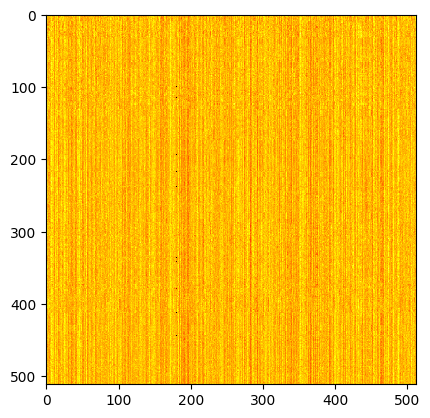

[False, True, True, False, False, True, True, False, False, True, True, False, False, False, True, True, False, True, False, False, False, True, False, False, True, False, True, True, True, True, False, False, True, False, True, True, True, True, False, False, True, True, False, True, False, False, False, False, True, False, False, True, False, True, True, False, False, False, True, False, True, False, True, False, True, False, False, False, False, False, False, False, False, True, True, False, False, False, True, True, True, False, False, False, False, True, True, True, False, True, True, False, True, False, True, False, False, False, False, True, False, True, False, True, True, False, True, True, True, False, False, True, False, False, True, False, True, False, False, False, True, True, True, False, True, True, False, False, False, True, True, False, True, False, True, True, True, False, True, False, False, False, True, False, True, True, False, True, False, True, False, False, False

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a specific attention head to visualize, for example, the first head in the last layer
layer = -1
head = 0
attention_head_matrix = attention_matrix[layer][1]#[head]

# Plot the attention matrix as a heatmap
# plt.figure(figsize=(12, 12))
# sns.heatmap(attention_matrix, xticklabels=input_tokens, yticklabels=input_tokens, cmap="viridis")
# plt.show()

print(len(input_tokens))

plt.imshow(attention_matrix, cmap='hot', interpolation='nearest')
# plt.xticks(range(len(input_tokens)), input_tokens)
# plt.yticks(range(len(input_tokens)), input_tokens)
plt.show()
print(bert_predicted)
print(test_y)


In [ ]:
# attention function based on http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention
def attention_transf(query, key, value):
    "Compute 'Scaled Dot Product Attention'"
    
    # scaling factor for scores
    d_k = query.size(-1)
    
    # matrix multiplication to get every dot product for query and transposed key
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    # apply softmax of the scores on the last dimensions (= sequence length)
    p_attn = F.softmax(scores, dim = -1)
    
    # matrix multiplication of attention matrix and value matrix to get output based
    out = torch.matmul(p_attn, value)
    
    return out, p_attn


torch.Size([768, 768])


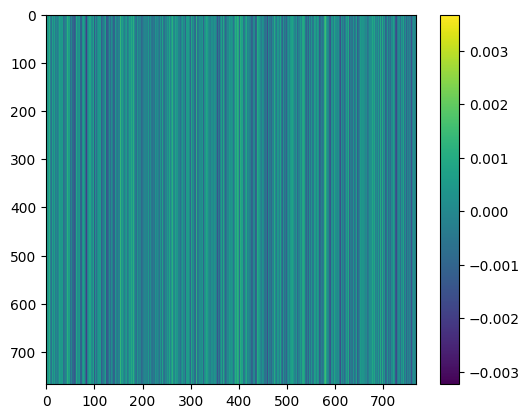

In [ ]:
#we have to find a way to extract Q,K,V from the weight matrices
#must torch.matmul by matrix X but idk what X is 
Q = bert_clf.bert.encoder.layer[0].attention.self.query.weight
K = bert_clf.bert.encoder.layer[0].attention.self.key.weight
V = bert_clf.bert.encoder.layer[0].attention.self.value.weight

out, att = attention_transf(Q, K, V)


print(out.shape)
out = out.cpu()
out = out.detach().numpy()

plt.imshow(out, cmap='viridis')  # You can change the colormap by changing 'viridis' to another colormap name
plt.colorbar()  # Show a color scale
plt.show()  # Display the heatmap
